In [2]:
cd wrkDir/sim/HSC-like-sim/

/work/xiangchong.li/work/massMapSparse/sim/HSC-like-sim


In [3]:
%pylab inline
import os
from pixel3D import cartesianGrid3D
from sparseBase import massmapSparsityTask
from configparser import ConfigParser
import astropy.io.fits as pyfits

Populating the interactive namespace from numpy and matplotlib


# Pixelation

In [6]:
poz=True
configName  =   os.path.join('./config-pix96-nl15.ini')
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)

# Simulation

In [12]:
deltaTrue=100   # input signal's magnitude
zlt=0.134
izlo=np.where((zlt>gridInfo.zlbound[:-1])&(zlt<=gridInfo.zlbound[1:]))[0][0]

C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc

def four_pi_G_over_c_squared():
    # = 1.5*H0^2/roh_0/c^2
    # We want it return 4piG/c^2 in unit of Mpc/M_solar
    # in unit of m/kg
    fourpiGoverc2 = 4.0*np.pi*GNEWTON/(C_LIGHT**2)
    # in unit of pc/M_solar
    fourpiGoverc2 *= KG_PER_SUN/M_PER_PARSEC
    # in unit of Mpc/M_solar
    fourpiGoverc2 /= 1.e6
    return fourpiGoverc2

if False:
    kl =   np.zeros(gridInfo.nz)
    mask=  (zlt<gridInfo.zcgrid)
    kl[mask] =   gridInfo.cosmo.Da(zlt,gridInfo.zcgrid[mask])*gridInfo.cosmo.Da(0.,zlt)\
        /gridInfo.cosmo.Da(0.,gridInfo.zcgrid[mask])
    kl*=four_pi_G_over_c_squared()
    rhoM_ave=gridInfo.cosmo.rho_m(zlt)
    DaBin=gridInfo.cosmo.Da(gridInfo.zlbound[izlo],gridInfo.zlbound[izlo+1])
    lkT=kl*rhoM_ave*DaBin
else:
    bfn='/work/xiangchong.li/work/S16ACatalogs/S16AStandardV2/field/pz_pdf_bins_mlz.fits'
    poz_bins=pyfits.getdata(bfn)['BINS']
    kl =   np.zeros(len(poz_bins))
    mask=  (zlt<poz_bins)
    kl[mask] =   gridInfo.cosmo.Da(zlt,poz_bins[mask])*gridInfo.cosmo.Da(0.,zlt)\
        /gridInfo.cosmo.Da(0.,poz_bins[mask])
    kl*=four_pi_G_over_c_squared()
    rhoM_ave=gridInfo.cosmo.rho_m(zlt)
    DaBin=gridInfo.cosmo.Da(gridInfo.zlbound[izlo],gridInfo.zlbound[izlo+1])
    lkT0=kl*rhoM_ave*DaBin
    pdfAve=pyfits.getdata('./pix96-nl15/poz_ave.fits')
    lkT=pdfAve.dot(lkT0)
if True:
    # not always at the center of the pixel
    gammat=np.matrix(lkT*deltaTrue).T
else:
    # at the center of the pixel
    gammat=np.matrix(lk[:,izlo]).T*deltaTrue

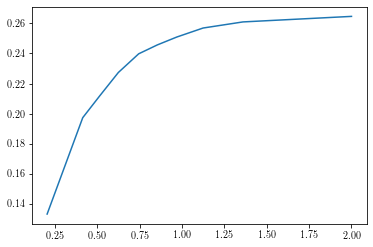

In [5]:
plt.plot(gridInfo.zcgrid,gammat)

shape of lensing kernel:  (10, 15)


(-0.5, 2.0)

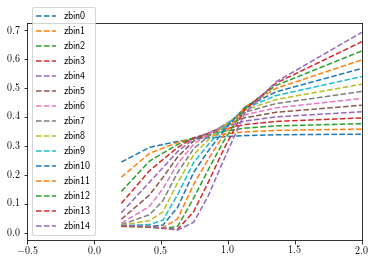

In [32]:
#lk=gridInfo.lensing_kernel()
lk= gridInfo.lensing_kernel(poz_grids=poz_bins,poz_ave=pdfAve)
lknorm=np.sqrt(np.sum(lk**2.,axis=0))
lk1=lk/lknorm[None,:]
print('shape of lensing kernel: ',lk1.shape)
for izl in range(0,15):
    norm1=np.sqrt(np.sum(lk1[:,izl]**2.))
    plt.plot(gridInfo.zcgrid,lk1[:,izl]/norm1,'--',label='zbin%d' %izl)
plt.legend(loc='lower left')
plt.xlim(-.5,2.)

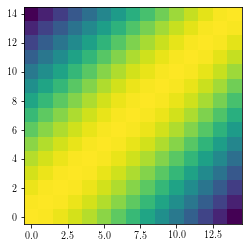

In [35]:
covariance=np.zeros((lk1.shape[1],lk1.shape[1]))
for i in range(lk1.shape[1]):
    for j in range(i,lk1.shape[1]):
        covariance[i,j]=np.sum(lk1[:,i]*lk1[:,j])
        covariance[j,i]=covariance[i,j]
plt.imshow(covariance,origin='lower')

In [34]:
nstep=1
A=np.matrix(lk1[:,::nstep])
lknormA=lknorm[::nstep]
if False:
    print('The trasfrom matrix is \n',A)
print(A.shape)
ndim=A.shape[0] # source redshift bins
if False:
    np.linalg.inv(A)*gammat2

(10, 15)


In [36]:
sigma_noi=0.005
nsim=200
std_ext=np.zeros((nsim,A.shape[1]))
for i in range(nsim):
    d= np.matrix(np.random.randn(ndim)*sigma_noi).T
    std_ext[i]=np.array(A.T.dot(d).T)[0]
stdnoi=np.std(std_ext,axis=0)

lbd=2.5          # sparse parameter
stdnoiUNorm=stdnoi/lknormA
SNR=deltaTrue/stdnoiUNorm[int(izlo//nstep)]

print("S/N of the input delta: %.3f" %SNR)
print("S/T of the input delta: %.3f" %(SNR/lbd) )
gammat=np.matrix(lk[:,izlo]).T*deltaTrue

S/N of the input delta: 135.567
S/T of the input delta: 54.227


# 2. Sparsity Regression
We then consider the $\chi^2$ fitting with sparsity reularization.
$$\rm{min}{(||\vec{\gamma}-\mathbf{A}\vec{x}||_2^2+\lambda \sigma(x) |\vec{x}|^1_1}).$$
The estimated $x$ should be
$$\vec{x}^{(n+1)}=S_\lambda(\vec{x}^{(n)}+\mathbf{A}^T (\vec{\gamma}-\mathbf{A}\vec{x}^{(n)})),$$
where $S_\lambda$ is the soft-thresholding function.

In [14]:
def soft_thresholding(dum,thresholds):
    # Standard Threshold Function
    return np.multiply(np.sign(dum),np.maximum(np.abs(dum)-thresholds,0.))

def solve_lasso(B,d,lbd,nadp=2):
    x=np.matrix(np.zeros(B.shape[1])).T
    mu=.05
    tn=1
    Xp0=x
    BT=B.T
    for i in range(8000):
        g=BT.dot((d-B.dot(x)))
        tmp=x+mu*g
        tmp=soft_thresholding(tmp,np.matrix(mu*lbd).T)
        tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
        ratio= (tn-1.)/tnTmp
        x    = tmp+(ratio*(tmp-Xp0))
        tn   = tnTmp
        Xp0  = tmp
        
    for j in range(nadp):
        tn=1
        Xp0=x
        xt=np.abs(np.array(x.T)[0])
        for i in range(800):
            g=BT.dot((d-B.dot(x)))
            tmp=x+mu*g
            tmp=soft_thresholding(tmp,np.matrix(mu*lbd/xt).T)
            tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
            ratio= (tn-1.)/tnTmp
            x    = tmp+(ratio*(tmp-Xp0))
            tn   = tnTmp
            Xp0  = tmp
    return x

S/N of the input delta: 146.019
S/T of the input delta: 1460.194


/data1b/work/xiangchong.li/superonionMaster/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


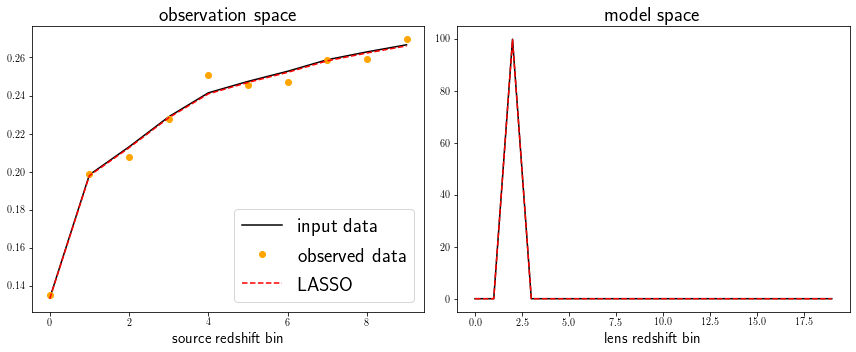

In [35]:
lbd=.1          # sparse parameter
stdnoiUNorm=stdnoi/lknormA
SNR=deltaTrue/stdnoiUNorm[int(izlo//nstep)]

print("S/N of the input delta: %.3f" %SNR)
print("S/T of the input delta: %.3f" %(SNR/lbd) )

gamma=gammat+np.matrix(np.random.randn(ndim)*sigma_noi).T
x_est=solve_lasso(A,gamma,lbd*stdnoi,2)
x_est2=np.divide(x_est.T,lknormA).T

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('observation space',fontsize=20)
ax.plot(gammat,label='input data',color='black')
ax.plot(gamma,'o',label='observed data',color='orange')
ax.plot(A*x_est,ls='--',label='LASSO',color='red')
#ax.plot(A*x_estA,ls='-.',label='Adaptive LASSO',color='blue')
ax.legend(fontsize=20)
ax.set_xlabel('source redshift bin',fontsize=15)

ax=fig.add_subplot(1,2,2)
ax.set_title('model space',fontsize=20)
xin=np.zeros(A.shape[1])
xin[int(izlo//nstep)]=deltaTrue
ax.plot(xin,label='input data',color='black')
ax.plot(x_est2,label='LASSO',ls='--',color='red')
#ax.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')
ax.set_xlabel('lens redshift bin',fontsize=15)

plt.tight_layout()

In [159]:
for i in range(1):
    gamma=gammat+np.matrix(np.random.randn(ndim)*sigma_noi).T
    x_est=solve_lasso(A,gamma,lbd*stdnoi,0)
    x_est2=np.divide(x_est.T,lknormA).T
    
    x_estA=solve_lasso(A,gamma,lbd*stdnoi,2)
    x_estA2=np.divide(x_estA.T,lknormA).T

S/N of the input delta: 128.420
S/T of the input delta: 51.368


/data1b/work/xiangchong.li/superonionMaster/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


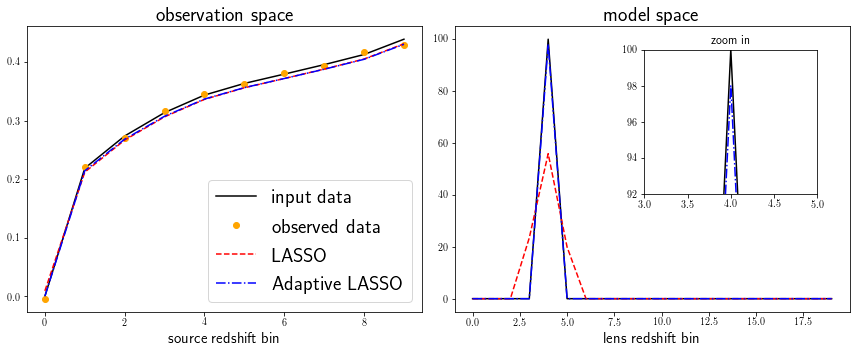

In [170]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('observation space',fontsize=20)
ax.plot(gammat,label='input data',color='black')
ax.plot(gamma,'o',label='observed data',color='orange')
ax.plot(A*x_est,ls='--',label='LASSO',color='red')
ax.plot(A*x_estA,ls='-.',label='Adaptive LASSO',color='blue')
ax.legend(fontsize=20)
ax.set_xlabel('source redshift bin',fontsize=15)

ax=fig.add_subplot(1,2,2)
ax.set_title('model space',fontsize=20)
xin=np.zeros(A.shape[1])
xin[int(izlo//nstep)]=deltaTrue
ax.plot(xin,label='input data',color='black')
ax.plot(x_est2,label='LASSO',ls='--',color='red')
ax.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')
ax.set_xlabel('lens redshift bin',fontsize=15)

ax2 = plt.axes([0.75, 0.45, 0.2, 0.4])
ax2.set_title('zoom in',fontsize=12)
ax2.set_ylim(92,100)
ax2.set_xlim(izlo-1,izlo+1)
ax2.plot(xin,label='input data',color='black')
ax2.plot(x_est2,label='LASSO',ls='--',color='red')
ax2.plot(x_estA2,label='Adaptive LASSO',ls='-.',color='blue')

plt.tight_layout()

In [96]:
from scipy import linalg
cov=lk1.T.dot(lk1)
linalg.pinv2(cov+0.00001*np.eye(15)).dot(lk1.T).dot(lk1)

array([[ 7.62175892e-01,  3.61864040e-01,  5.09569407e-02,
        -1.18671953e-01, -1.27588564e-01, -2.01502246e-02,
         7.14272385e-02,  5.53910947e-02, -4.29181642e-03,
        -3.32766134e-02, -1.67056095e-02,  1.22715678e-02,
         1.57136601e-02, -1.07904502e-02,  1.23140916e-03],
       [ 3.61864040e-01,  2.94979874e-01,  2.20576651e-01,
         1.40443620e-01,  5.69941972e-02, -1.83195423e-02,
        -5.24402008e-02, -2.89326521e-02,  7.93611911e-03,
         2.10867231e-02,  7.87905166e-03, -9.20606648e-03,
        -8.87215426e-03,  7.91885361e-03, -1.35784574e-03],
       [ 5.09569407e-02,  2.20576651e-01,  3.19618622e-01,
         3.16044747e-01,  2.00139234e-01,  1.65126319e-02,
        -1.02171002e-01, -7.17520819e-02,  9.30343440e-03,
         4.50131059e-02,  2.08437265e-02, -1.71199238e-02,
        -2.04456223e-02,  1.43686752e-02, -1.65129228e-03],
       [-1.18671953e-01,  1.40443620e-01,  3.16044747e-01,
         3.66586706e-01,  2.77673138e-01,  9.42566950

In [86]:
lk1.T.dot(lk1)+0.1

array([[1.01      , 1.007906  , 1.00153962, 0.99113858, 0.97681999,
        0.95830133, 0.93677142, 0.91372468, 0.88858326, 0.86190157,
        0.83421126, 0.80505007, 0.77516294, 0.74517179, 0.71448925],
       [1.007906  , 1.01      , 1.00784251, 1.00146079, 0.99087014,
        0.97574836, 0.95705101, 0.93615832, 0.91274768, 0.88744233,
        0.86073112, 0.83215757, 0.80247328, 0.77232319, 0.74122582],
       [1.00153962, 1.00784251, 1.01      , 1.00785086, 1.00131913,
        0.99003527, 0.97467019, 0.9564403 , 0.93525137, 0.91176574,
        0.88641801, 0.85876871, 0.82957387, 0.79950066, 0.7681881 ],
       [0.99113858, 1.00146079, 1.00785086, 1.01      , 1.00776068,
        1.00070748, 0.98917168, 0.97414752, 0.9557187 , 0.93454379,
        0.9109908 , 0.88465109, 0.85628258, 0.82657271, 0.79529353],
       [0.97681999, 0.99087014, 1.00131913, 1.00776068, 1.01      ,
        1.00754758, 1.00034068, 0.98909042, 0.97399573, 0.95566139,
        0.93437574, 0.90977513, 0.88261497, 